# Read in the data

In [5]:
import pandas as pd
import numpy
import re
import os
print()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}
data_dir = os.environ['DATA_DIR']
for f in data_files:
    d = pd.read_csv(data_dir + '/schools/' + "{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [6]:
all_survey = pd.read_csv(data_dir + "/schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv(data_dir + "/schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/usr/local/applications/anaconda3/envs/sid_datascience/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


# Add DBN columns

In [7]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [8]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [9]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [10]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [11]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [12]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [13]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
Total Grads - % of cohort               0.584234
Total Regents - % of cohort             0.667603
Total Regents - % of grads              0.494732
Advanced Regents - % of cohort          0.771566
Advanced Regents - % of grads           0.739927
Regents w/o Advanced - % of cohort     -0.138188
Regents w/o Advanced - % of grads      -0.456213
Local - % of cohort                    -0.467951
Local - % of grads                     -0.494732
Still Enrolled - % of cohort           -0.491914
Dropped Out - % of cohort              -0.458537
CSD                                     0.042948
NUMBER OF STUDENTS /

# Plotting survey correlations

In [14]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

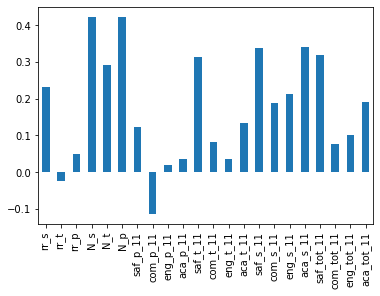

In [15]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

# Exploring Safety

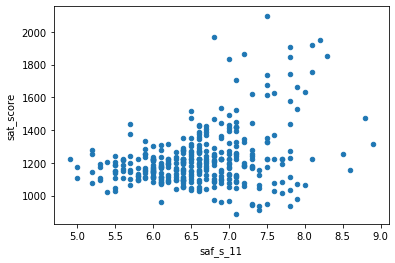

In [16]:
combined.plot.scatter("saf_s_11", "sat_score")

# Plotting Safefy

/usr/local/applications/anaconda3/envs/sid_datascience/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
/usr/local/applications/anaconda3/envs/sid_datascience/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


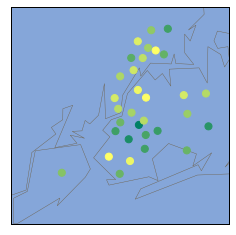

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

# Racial difference in SAT score

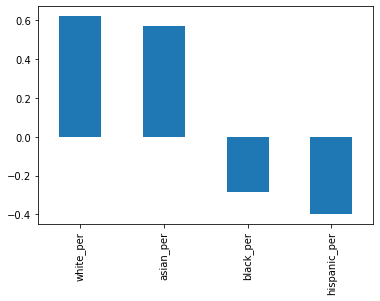

In [18]:
racial_types = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
correlations[racial_types].plot.bar()

For black and hispanic have higher % of people with low SAT score and  vice-versa

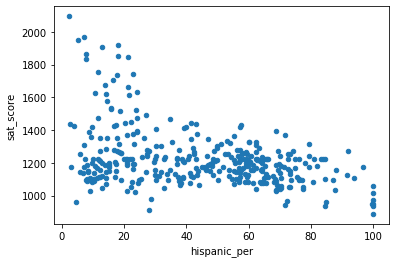

In [19]:
combined.plot.scatter("hispanic_per", "sat_score")

Not a lot of datapoints where low % of hispanics, SAT score is higher. But it definitely says that as a higher % of hispanics in a school have lower SAT score.

In [20]:
school_95hispanics = combined[combined['hispanic_per'] >= 95]
school_95hispanics['SchoolName']

44             Manhattan Bridges High School
82                                         0
89            GREGORIO LUPERON HS SCI & MATH
125      Academy for Language and Technology
141    International School for Liberal Arts
176                                        0
253                Multicultural High School
286                                        0
Name: SchoolName, dtype: object

In all the above schools with more than 95% of hispanics, atleast 90% of students are economically disadvantaged.

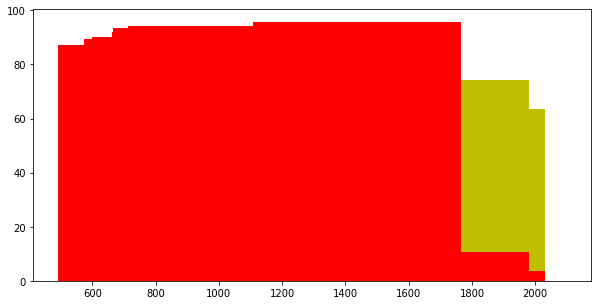

In [21]:
school_10hispanics = combined[combined['hispanic_per'] < 10]
school_10hispanics = school_10hispanics[school_10hispanics['sat_score'] > 1000]
plt.figure(figsize=(10,5))
# school_10hispanics[['white_per','asian_per','black_per']].plot.bar()
plt.bar(school_10hispanics['sat_score'], school_10hispanics['white_per'], width=0.5, color='b')
plt.bar(school_10hispanics['sat_score'], school_10hispanics['asian_per'], width=0.5, color='y')
plt.bar(school_10hispanics['sat_score'], school_10hispanics['black_per'], width=0.5, color='r')
plt.show()

Asians and White are the high scorers in SAT. Even after looking at poulations of schools with < 10% of hispanics and > 1000 score, black people tend to score lower. Asians lead the results

# Gender Difference

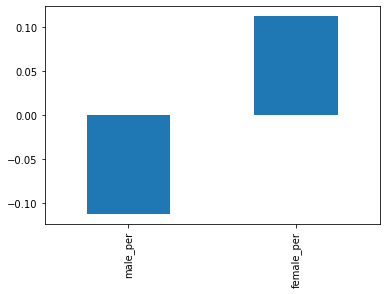

In [22]:
correlations[['male_per','female_per']].plot.bar()

Females have higher SAT scores than males

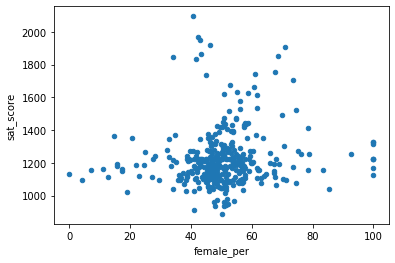

In [23]:
combined.plot.scatter('female_per', 'sat_score')

With the given data points, it's hard to say that higher SAT score is dominated with schools having higher female %. There are some data pints where female % is 100 but still SAT score is low.

In [24]:
fschool_60_1700 = combined[combined['female_per'] > 60]
fschool_60_1700 = fschool_60_1700[fschool_60_1700['sat_score'] > 1700]
fschool_60_1700['SchoolName']

5                                  0
26     Eleanor Roosevelt High School
60                     BEACON SCHOOL
61           FIORELLO H.LAGUARDIA HS
302               TOWNSEND HARRIS HS
Name: SchoolName, dtype: object

Elanor - 130 national rank, 60% females, white mostly, 21% economically disadvantaged
Beacon high school - 345 rank, 64% females, 24% disadvantaged 
FIORELLO H.LAGUARDIA HS - 265 rank 29% disadvantaged, 75%females
TOWNSEND HARRIS HS - 11 rank 54% disadvantaged, 69% females with 54% Asian. 

Most of these schools have higher rankings which confirms the fact that these schools have more students with high score.


# % of AP exam takers vs SAT score

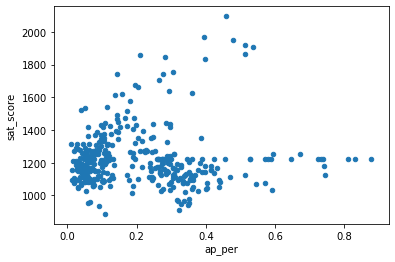

In [25]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter('ap_per', 'sat_score')

Do not see a strong relationship with higher % of AP takers having a high sat score.

# Class size vs SAT score

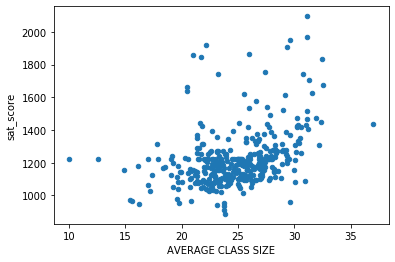

In [26]:
# combined.info(verbose=True)
combined.plot.scatter('AVERAGE CLASS SIZE', 'sat_score')

There's a linear relationship (positive) between average class size and sat score. Higher average class size, higher the sat score.

# Neighborhoods with best schools

Data Source: https://www.zillow.com/research/data/

Study the relationship between rate/sq feet vs average home rate per zipcode to make sure it's linear. This is done to ensure consistency of data. If it holds true, then either of dataset can be used. 

## Load property data for NYC in DF

In [27]:
median_value_per_home_zip_file = 'median_value_per_home_zip.csv'
median_value_per_sqft_homes_zip_file = 'median_value_per_sqft_homes_zip.csv' 
data_files.append(median_value_per_home_zip_file)
data_files.append(median_value_per_sqft_homes_zip_file)

home_value = pd.read_csv(data_dir + '/schools/' + median_value_per_home_zip_file, sep=',', encoding='utf-8')
home_value_sqft = pd.read_csv(data_dir + '/schools/' + median_value_per_sqft_homes_zip_file, sep=',', encoding='utf-8')

# Get the data for state = NYC
home_value['State'] = home_value['State'].str.upper()
home_value_sqft['State'] = home_value_sqft['State'].str.upper()
home_value = home_value[home_value['State'] == 'NY']
home_value_sqft = home_value_sqft[home_value_sqft['State'] == 'NY']


## Rename the columns of home_value and home_value_sqft DF

In [28]:
home_value_columns = ["RegionID","RegionName","City","State","Metro","CountyName", "2014-01","2014-02","2014-03","2014-04","2014-05","2014-06","2014-07","2014-08","2014-09","2014-10","2014-11","2014-12"]
home_value_sqft_columns = ["RegionID","RegionName","City","State","Metro","CountyName", "2014-01","2014-02","2014-03","2014-04","2014-05","2014-06","2014-07","2014-08","2014-09","2014-10","2014-11","2014-12"]

home_value = home_value[home_value_columns]
home_value_sqft = home_value_sqft[home_value_sqft_columns]
rename_zip_dict = {'RegionName' : 'zipcode'}

home_value.rename(rename_zip_dict, axis=1, inplace=True)
home_value_sqft.rename(rename_zip_dict, axis=1, inplace=True)

# Rename columns of both the DF
home_value_rename_col_dict = {'2014-01': '2014-01(full)', "2014-02":"2014-02(full)", "2014-03":"2014-03(full)", "2014-04":"2014-04(full)", "2014-05":"2014-05(full)", "2014-06":"2014-06(full)", "2014-07":"2014-07(full)", "2014-08":"2014-08(full)", "2014-09":"2014-09(full)", "2014-10":"2014-10(full)", "2014-11":"2014-11(full)", "2014-12":"2014-12(full)"}
home_value_sqft_rename_col_dict = {'2014-01': '2014-01(sqft)', "2014-02":"2014-02(sqft)", "2014-03":"2014-03(sqft)", "2014-04":"2014-04(sqft)", "2014-05":"2014-05(sqft)", "2014-06":"2014-06(sqft)", "2014-07":"2014-07(sqft)", "2014-08":"2014-08(sqft)", "2014-09":"2014-09(sqft)", "2014-10":"2014-10(sqft)", "2014-11":"2014-11(sqft)", "2014-12":"2014-12(sqft)"}
home_value.rename(home_value_rename_col_dict, axis=1, inplace=True)
home_value_sqft.rename(home_value_sqft_rename_col_dict, axis=1, inplace=True)



## Join the dataset by zipcode

In [29]:
# home_value.info(verbose=True)
# home_value_sqft.info(verbose=True)

home_cost = home_value.merge(home_value_sqft, on='zipcode', how='left')
home_cost.info(verbose=True)

## Examine for null values
# missing_df = home_cost[home_cost['2014-01(sqft)'].isnull()]
## The missing data is because a few zipcodes are absent in home_value_sqft.



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 0 to 1084
Data columns (total 35 columns):
RegionID_x       1085 non-null int64
zipcode          1085 non-null int64
City_x           1085 non-null object
State_x          1085 non-null object
Metro_x          1018 non-null object
CountyName_x     1085 non-null object
2014-01(full)    1084 non-null float64
2014-02(full)    1084 non-null float64
2014-03(full)    1084 non-null float64
2014-04(full)    1084 non-null float64
2014-05(full)    1084 non-null float64
2014-06(full)    1084 non-null float64
2014-07(full)    1085 non-null float64
2014-08(full)    1085 non-null float64
2014-09(full)    1085 non-null float64
2014-10(full)    1085 non-null float64
2014-11(full)    1085 non-null float64
2014-12(full)    1085 non-null float64
RegionID_y       1004 non-null float64
City_y           1004 non-null object
State_y          1004 non-null object
Metro_y          938 non-null object
CountyName_y     1004 non-null object
2014-01(s

## Correlate 

In [30]:
correlation = home_cost.corr()
correlation['2014-02(full)']
## Check for any month of 2014 and you will find high correlation values across all
## months of 2014 for 2014(sqft) rates and vice-versa

RegionID_x       0.123160
zipcode         -0.629581
2014-01(full)    0.999951
2014-02(full)    1.000000
2014-03(full)    0.999941
2014-04(full)    0.999784
2014-05(full)    0.999546
2014-06(full)    0.999254
2014-07(full)    0.998943
2014-08(full)    0.998685
2014-09(full)    0.998506
2014-10(full)    0.998303
2014-11(full)    0.998089
2014-12(full)    0.997810
RegionID_y       0.132202
2014-01(sqft)    0.884378
2014-02(sqft)    0.883942
2014-03(sqft)    0.882956
2014-04(sqft)    0.882115
2014-05(sqft)    0.881676
2014-06(sqft)    0.881245
2014-07(sqft)    0.881161
2014-08(sqft)    0.881351
2014-09(sqft)    0.881212
2014-10(sqft)    0.880836
2014-11(sqft)    0.880626
2014-12(sqft)    0.880393
Name: 2014-02(full), dtype: float64

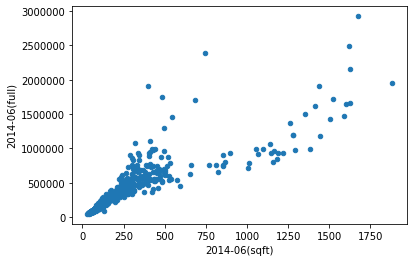

In [31]:
home_cost.plot.scatter('2014-06(sqft)','2014-06(full)' )
## This shows that relation between sqft cost vs full house cost is linear. During higher value
## of $/sqft, the rate of increase is not much as for lower values of $/sqft. 

## Compare property data and school score

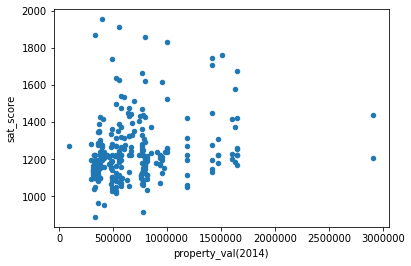

In [32]:


combined = combined.merge(home_value, left_on='postcode', right_on='zipcode', how='left')
## Drop rows where no property data can be found for some zipcodes

combined = combined.dropna(subset=['zipcode'])
# combined.info(verbose=True)

columns = ['2014-01(full)', '2014-02(full)', '2014-03(full)', '2014-04(full)', '2014-05(full)', '2014-06(full)', '2014-07(full)', '2014-08(full)','2014-09(full)', '2014-10(full)', '2014-11(full)', '2014-12(full)']   
combined['property_val(2014)'] = combined[columns].mean(axis=1)
combined.head()
combined.plot.scatter('property_val(2014)', 'sat_score')

According to above graph, there is no relationship between property value and sat score. So a school can be in a less expensive neighbourhood and still a good school.

# Investing differences between parent, teacher and student responses in the survey

The survey fields tracking the responses of parent, teacher and student are "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11"

In [33]:
correlations = combined.corr()
## Examine the fields saf_t_11 and saf_s_11
correlations['saf_p_11'] 

## Examine the fields com_t_11 and com_s_11
correlations['com_p_11']

## Examine the fields eng_t_11 and eng_s_11
correlations['eng_p_11']

## Examine the fields aca_t_11 and aca_s_11
correlations['aca_p_11']

SAT Critical Reading Avg. Score         0.090868
SAT Math Avg. Score                     0.078348
SAT Writing Avg. Score                  0.117356
sat_score                               0.097235
AP Test Takers                         -0.097788
Total Exams Taken                      -0.092283
Number of Exams with scores 3 4 or 5   -0.045961
Total Cohort                           -0.306600
Total Grads - % of cohort               0.267527
Total Regents - % of cohort             0.233819
Total Regents - % of grads              0.077864
Advanced Regents - % of cohort          0.090031
Advanced Regents - % of grads           0.030069
Regents w/o Advanced - % of cohort      0.170222
Regents w/o Advanced - % of grads       0.022946
Local - % of cohort                    -0.048221
Local - % of grads                     -0.077864
Still Enrolled - % of cohort           -0.232186
Dropped Out - % of cohort              -0.191128
CSD                                    -0.067666
NUMBER OF STUDENTS /